## Dataset : Drone trajectory Dataset based on DJI simulator

In [ ]:
# ! pip install verstack

In [36]:
# import & call data
import numpy as np
import pandas as pds
import os
from numpy import array

data = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData15.csv'),
)
data_1 = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData11.csv'),
)
data_2 = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData12.csv'),
)
data_3 = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData13.csv'),
)
data_4 = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData14.csv'),
)

# upload the data files
data_test = pds.read_csv(
    os.path.join('UAVDataset/second3/uavTrajectoryData10.csv'),
)

# Pre-Processing

Data has a different trajectory in a one data. 
Our goal is building a 10 sequential data so the seperate trajcetory doesn't make a data like teleporting (start with one of end position, end with one of start position)

1. seperate data as a train data, target data.
2. concatenate all of data as a one train, target data.

In [37]:
def sep_train2target(datas):             # separate the dataset as train, target
    datas = datas.dropna()
    dataset = datas[['time', 'lat', 'lon', 'alt']]
    lat_frame = dataset['lat']
    lon_frame = dataset['lon']
    alt_frame = dataset['alt']
    
    data_train = []
    data_target = []
    for i in range(len(dataset) - 10):   # set the 30 features and target data
        temp_train = []
        temp_target = []
        for j in range(i,i+10):
            temp_train.append(lat_frame[j])
            temp_train.append(lon_frame[j])
            temp_train.append(alt_frame[j])
        temp_target.append(lat_frame[i+10])
        temp_target.append(lon_frame[i+10])
        temp_target.append(alt_frame[i+10])
        np.array(temp_train)
        np.array(temp_target)
        data_train.append(temp_train)
        data_target.append(temp_target)

    data_train = np.asarray(data_train)
    data_target = np.asarray(data_target)
    
    return data_train, data_target

In [38]:
data_train, data_target = sep_train2target(data)
data_train_1, data_target_1 = sep_train2target(data_1)
data_train_2, data_target_2 = sep_train2target(data_2)
data_train_3, data_target_3 = sep_train2target(data_3)
data_train_4, data_target_4 = sep_train2target(data_4)
# data_train_5, data_target_5 = sep_train2target(data_5)
# data_train_6, data_target_6 = sep_train2target(data_6)
# data_train_7, data_target_7 = sep_train2target(data_7)

test_train, test_target = sep_train2target(data_test)
# data_train_4, data_target_4 = sep_train2target(data_4)
# data_train_5, data_target_5 = sep_train2target(data_5)
# data_train_6, data_target_6 = sep_train2target(data_6)
# data_train_7, data_target_7 = sep_train2target(data_7)
# data_train_8, data_target_8 = sep_train2target(data_8)

In [39]:
def merge_data(main, sub):
    return np.concatenate((main, sub), axis = 0)

def array2series(target):
    result_lat = target[: ,0]
    result_lat = pds.DataFrame(result_lat)
    result_lat = result_lat.squeeze()
    
    result_log = target[: ,1]
    result_log = pds.DataFrame(result_log)
    result_log = result_log.squeeze()
    
    result_alt = target[: ,2]
    result_alt = pds.DataFrame(result_alt)
    result_alt = result_alt.squeeze()
    
    return result_lat, result_log, result_alt

In [40]:
data_train_list = [data_train_1, data_train_2, data_train_3, data_train_4]
data_target_list = [data_target_1, data_target_2, data_target_3, data_target_4]
train_final = data_train
target_final = data_target
data_train_list
for i in range(len(data_train_list)):
    train_final = merge_data(train_final, data_train_list[i])
    target_final = merge_data(target_final, data_target_list[i])

target_lat, target_lon, target_alt = array2series(target_final)
test_target_lat, test_target_lon, test_target_alt = array2series(test_target) 

In [41]:
len(target_final), len(test_target)

(3577, 403)

# Set the target data: 

Seperate the data with a feature type(lat, lon, alt)


In [42]:
import verstack
from verstack.stratified_continuous_split import scsplit    # KFold is not available. 
train_final = pds.DataFrame(train_final)      # KFold supports classification data. But our data type is continuous
target_data = target_lat                      # set the target data : [target_lat, target_lon, target_alt]
X_train, X_val, y_train, y_val = scsplit(train_final, target_data, stratify = target_data)
# X_train, y_train type => pds.DataFrame  X_val, y_val type => pds.Series
X_lon_train, X_lon_val, y_lon_train, y_lon_val = scsplit(train_final, target_lon, stratify = target_lon)
X_alt_train, X_alt_val, y_alt_train, y_alt_val = scsplit(train_final, target_alt, stratify = target_alt)

In [43]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
def make_MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def eval_model(true_list, pre_list):
    MAE = mean_absolute_error(true_list, pre_list)
    MSE = mean_squared_error(true_list, pre_list)
    RMSE = np.sqrt(MSE)
    pre_list = pds.DataFrame(pre_list)
    pre_list = pre_list.squeeze()
    MAPE = make_MAPE(true_list, pds.Series(pre_list))
    return MAE, RMSE, MAPE

def make_error_list(total_list):
    MAE_list = [total_list[0][0], total_list[1][0], total_list[2][0]]
    RMSE_list = [total_list[0][1], total_list[1][1], total_list[2][1]]
    MAPE_list = [total_list[0][2], total_list[1][2], total_list[2][2]]
    return MAE_list, RMSE_list, MAPE_list

## Code Visualize

In [44]:
from matplotlib import pyplot as plt

def draw_graph(model_name, short_model_name, test_predict, error_list):
    x = np.arange(len(test_target))              # Linear Regression Visualization

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    fig.show()
    # X_val, y_val, y_predict
    ax[0][0].title.set_text(f"{model_name} Regression Test (lat)")
    ax[0][0].plot(x, test_target_lat, color = 'tab:blue', label='real')
    ax[0][0].plot(x, test_predict[0], color = 'tab:red', label='predict')
    ax[0][0].legend()


    ax[0][1].title.set_text(f"{model_name} Regression Test (lon)")
    ax[0][1].plot(x, test_target_lon, color = 'tab:blue', label='real')
    ax[0][1].plot(x, test_predict[1], color = 'tab:red', label='predict')
    ax[0][1].legend()

    ax[1][0].title.set_text(f"{model_name} Regression Test (alt)")
    ax[1][0].plot(x, test_target_alt, color = 'tab:blue', label='real')
    ax[1][0].plot(x, test_predict[2], color = 'tab:red', label='predict')
    ax[1][0].legend()

    TMAE_list, TRMSE_list, TMAPE_list = make_error_list(error_list)
    model_error_list.append((f'{short_model_name}_MAE', np.mean(TMAE_list)))
    model_error_list.append((f'{short_model_name}_RMSE', np.mean(TRMSE_list)))
    model_error_list.append((f'{short_model_name}_MAPE', np.mean(TMAPE_list)))
    errors = np.arange(3)
    err_values = [np.mean(TMAE_list), np.mean(TRMSE_list), np.mean(TMAPE_list)]
    err_names = ['MAE', 'RMSE', 'MAPE']
    ax[1][1].title.set_text(f"{model_name} Regression")
    ax[1][1].bar(errors, err_values)
    plt.setp(ax[1][1], xticks=errors, xticklabels=err_names)

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def show_3D_trajectory(fig, idx, result_list, title):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    ax.set_title(title)
   
    x = result_list[0].transpose().squeeze()
    y = result_list[1].transpose().squeeze()
    z = result_list[2].transpose().squeeze()
    
    true_x = test_target_lat
    true_y = test_target_lon
    true_z = test_target_alt
    
    ax.plot(true_x, true_y, true_z, color = 'b', label = 'True Trajectory')
    ax.plot(x, y, z, color = 'r', label = title +' Trajectory')

    ax.legend()
    # ax.scatter(x, y, z, color = 'r', alpha = 0.5)
    # ax.scatter(true_x, true_y, true_z, color = 'b', alpha = 0.5)

# Linear Regression 

When VIF value is larger than 10, consider the train variable has multicollinearity.<br>
In this case, use Ridge to make this feature go low.


In [46]:
def vif_ridge(corr_x, pen_factors, is_corr=True):
    corr_x = np.asarray(corr_x)
    if not is_corr:
        corr = np.corrcoef(corr_x, rowvar=0, bias=True)
    else:
        corr = corr_x

    eye = np.eye(corr.shape[1])
    res = []
    for k in pen_factors:
        minv = np.linalg.inv(corr + k * eye)
        vif = minv.dot(corr).dot(minv)

        cnt = 0
        for item in np.diag(vif):
            if item > 10:
                cnt += 1
        res.append(cnt)
    return np.asarray(res)

In [47]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    # check the Multicollinearity
vif = pds.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(train_final.values, i)
                        for i in range(train_final.shape[1])]
vif['Feature'] = train_final.columns

# check the original value's  multicollinearity is over than 10
cnt = 0
for item in vif['VIF_Factor']:
    if item > 10:
       cnt += 1

print(vif['VIF_Factor'].size == cnt)

True


## Normailze
To earn a generalized result, datas have been normalized by standardscaler.

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# latitude
model_error_list = []    # error per model
scx_list, scy_list = [], []
trainx_list = [X_train, X_lon_train, X_alt_train]
trainy_list = [y_train, y_lon_train, y_alt_train]
validX_list = [X_val, X_lon_val, X_alt_val]
validy_list = [y_val, y_lon_val, y_alt_val]
test_list = [test_target_lat, test_target_lon, test_target_alt]

stdX_list, stdy_list = [], []
stdX_val_list, stdX_test_list = [], []

LR_predict_list = []
LR_error_list = []
LR_test_result_list = []    # test result data list
LR_test_error_list = []     # test error list

stdX_list = []
stdy_list = []
stdX_val_list = []

for i in range(3):        # Standard normalization
    sc_x = StandardScaler()
    sc_y = StandardScaler()
    
    stdX_list.append(sc_x.fit_transform(trainx_list[i]))
    stdy_list.append(sc_y.fit_transform(trainy_list[i].values.reshape((-1, 1))))
    
    stdX_val_list.append(sc_x.transform(validX_list[i]))
    stdX_test_list.append(sc_x.transform(test_train))
    scx_list.append(sc_x)
    scy_list.append(sc_y)

## find best parameter in Ridge regression
We test 3 models performance which is lat, lon and alt.
<br>
That is why loop code is here

In [49]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

Ridge_alpha_list = []
Ridge_predict_list = []
Ridge_error_list = []
for i in range(3):
    # checking with grid search
    parameters = {'alpha':[1,2,3,4,5]}
    Ridge_reg= GridSearchCV(Ridge(), parameters, scoring='neg_mean_squared_error',cv=5)
    Ridge_reg.fit(stdX_list[i], stdy_list[i])
    
    # now apply the best param to train
    Ridge_alpha_list.append(Ridge_reg.best_params_["alpha"])
    reg = Ridge(alpha=Ridge_reg.best_params_["alpha"]).fit(stdX_list[i], stdy_list[i])
       
    predict_test = reg.predict(stdX_test_list[i])
    predict_test = scy_list[i].inverse_transform(predict_test.reshape((-1, 1)))
    
    TMAE, TRMSE, TMAPE = eval_model(test_list[i], predict_test)
    Ridge_predict_list.append(predict_test)
    Ridge_error_list.append([TMAE, TRMSE, TMAPE])

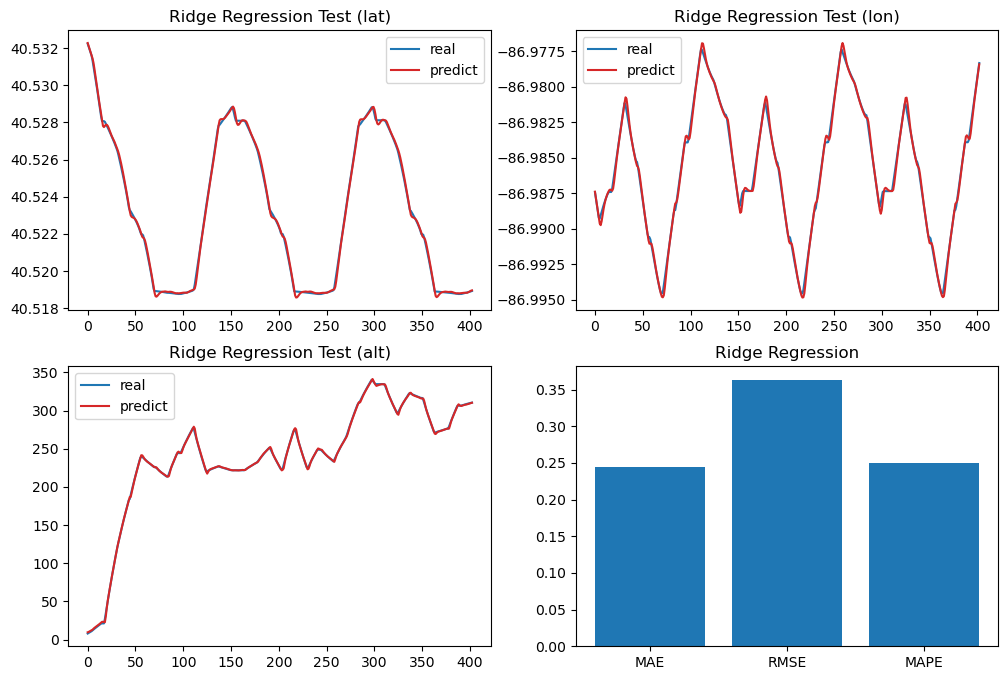

In [50]:
draw_graph("Ridge", "TRidge", Ridge_predict_list, Ridge_error_list)

# Ensemble: model  type = LinearRegression

## check how many model to use with GridSearch

In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor

BR_best_predict_list = []
BR_best_error_list = []

BR_best_test_predict_list = []
BR_best_test_error_list = []

BR_best_params = []

for i in range(3):
    parameters = {
    "n_estimators": [5, 10, 30]
    }

    grid = GridSearchCV(BaggingRegressor(), parameters, cv=5, verbose=1)
    grid.fit(stdX_list[i], stdy_list[i])
    BR_best_params.append(grid.best_params_["n_estimators"])
    
    regr_best = BaggingRegressor(LinearRegression(), n_estimators= grid.best_params_["n_estimators"], random_state=0).fit(stdX_list[i], stdy_list[i])
    ensemble_predict_best = regr_best.predict(stdX_val_list[i])
    ensemble_predict_best = sc_y.inverse_transform(ensemble_predict_best.reshape((-1, 1)))
    
    predict_test = regr_best.predict(stdX_test_list[i])
    predict_test = scy_list[i].inverse_transform(predict_test.reshape((-1, 1)))
    
    
    MAE, RMSE, MAPE = eval_model(validy_list[i], ensemble_predict_best)
    BR_best_predict_list.append(ensemble_predict_best)
    BR_best_error_list.append([MAE, RMSE, MAPE])
    
    TMAE, MRMSE,TMAPE = eval_model(test_list[i], predict_test)
    BR_best_test_predict_list.append(predict_test)
    BR_best_test_error_list.append([TMAE, TRMSE, TMAPE])

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


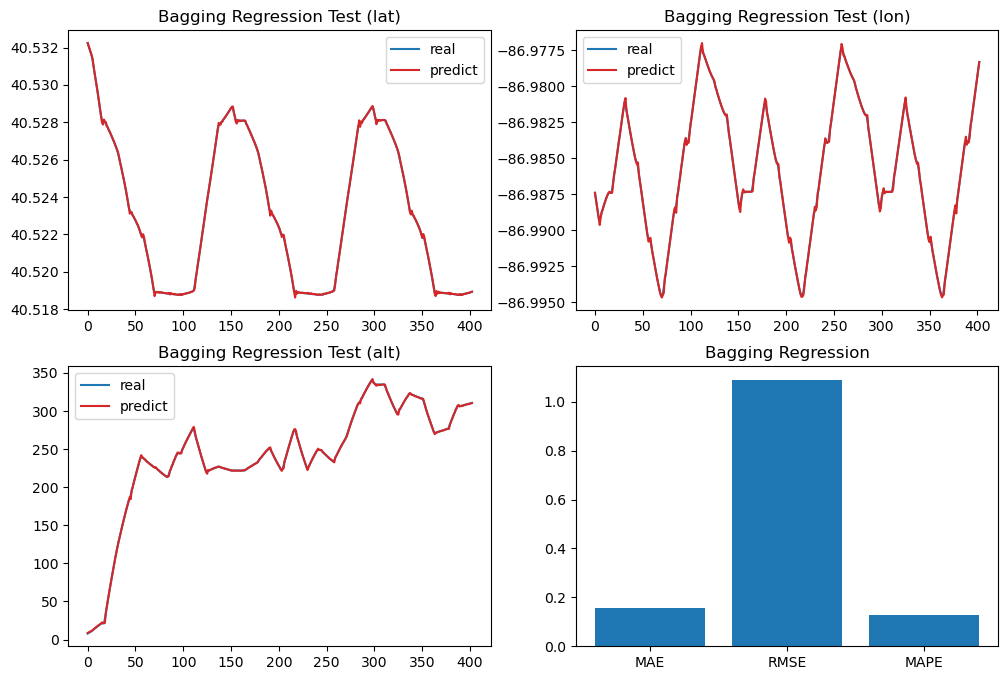

In [52]:
draw_graph("Bagging", "TBR", BR_best_test_predict_list, BR_best_test_error_list)

# Support Vector Machine (SVM) :

# apply SVM 
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import make_pipeline

regr_svm = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
regr_svm.fit(X_train, y_train)
predict_svm = regr_svm.predict(X_val)

svm_MAE = mean_absolute_error(y_val,predict_svm)
svm_MSE = mean_squared_error(y_val, predict_svm)
svm_RMSE = np.sqrt(svm_MSE)
svm_MAPE = make_MAPE(y_val, predict_svm)

predict_svm

In [53]:
# apply SVM 
from sklearn.svm import LinearSVR, SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

rbf_predict_list = []
rbf_error_list = []
rbf_test_predict_list = []
rbf_test_error_list = []
rbf_best_params = []
for i in range(3):
    parameters = {
    "kernel": ['rbf'],
    "C": [1, 10, 100, 1000, 10000],
    "gamma": [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
    }
     
    grid = GridSearchCV(SVR(), parameters,cv=5, verbose=1)
    grid.fit(stdX_list[i], stdy_list[i])
    
    print("running now")
    
    rbf_best_params.append([grid.best_params_["gamma"], grid.best_params_["C"]])
    svr = SVR(kernel="rbf", gamma=grid.best_params_["gamma"], C=grid.best_params_["C"])
    svr.fit(stdX_list[i], stdy_list[i])
    
    predict_svr = svr.predict(stdX_val_list[i])
    predict_svr = scy_list[i].inverse_transform(predict_svr.reshape((-1, 1)))
    
    predict_test = svr.predict(stdX_test_list[i])
    predict_test = scy_list[i].inverse_transform(predict_test.reshape((-1, 1)))
    
#     MAE, RMSE, MAPE = eval_model(validy_list[i], predict_svr)
#     rbf_predict_list.append(predict_svr)
#     rbf_error_list.append([MAE, RMSE, MAPE])
    TMAE, TRMSE, TMAPE = eval_model(test_list[i], predict_test)
    rbf_test_predict_list.append(predict_test)
    rbf_test_error_list.append([TMAE, TRMSE, TMAPE])

Fitting 5 folds for each of 40 candidates, totalling 200 fits
running now
Fitting 5 folds for each of 40 candidates, totalling 200 fits
running now
Fitting 5 folds for each of 40 candidates, totalling 200 fits
running now


for i in range(3):
    temp = SVR(kernel="rbf")
    temp.fit(stdX_list[i], stdy_list[i])
    print(1 / (stdX_list[i].var() * 30))

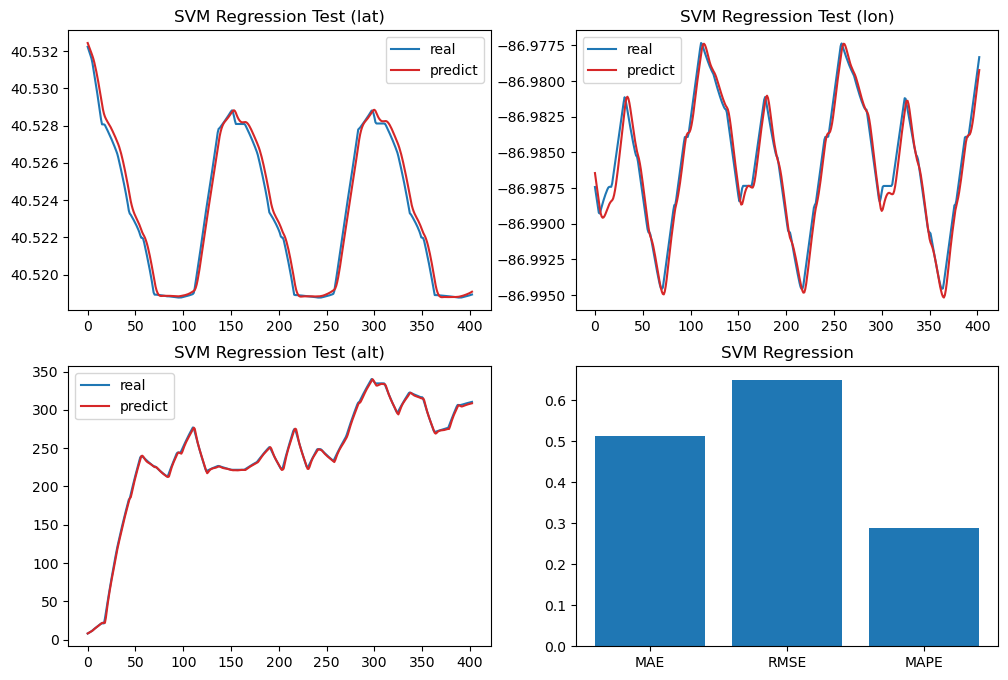

In [54]:
draw_graph("SVM", "rbf", rbf_test_predict_list, rbf_test_error_list)

## Check all of error

In [55]:
model_error_list = dict(model_error_list)
model_error_list

{'TRidge_MAE': 0.24422725769211695,
 'TRidge_RMSE': 0.36359883970092527,
 'TRidge_MAPE': 0.2502159599687385,
 'TBR_MAE': 0.15569445020236458,
 'TBR_RMSE': 1.090408677454304,
 'TBR_MAPE': 0.12954214746738776,
 'rbf_MAE': 0.5126777576594889,
 'rbf_RMSE': 0.6505543503226148,
 'rbf_MAPE': 0.28755117741384795}

In [56]:
model_error_list = dict(model_error_list)
model_error_list
cols = ['MAE', "RMSE", "MAPE"]
idx = ['Ridge','SVM','Ensemble']
temp =[[model_error_list['TRidge_MAE'], model_error_list['TRidge_RMSE'], model_error_list['TRidge_MAPE']],
       [model_error_list['rbf_MAE'],model_error_list['rbf_RMSE'],model_error_list['rbf_MAPE']],
       [model_error_list['TBR_MAE'],model_error_list['TBR_RMSE'],model_error_list['TBR_MAPE']]]
compare_ensemble = pds.DataFrame(temp, columns=cols, index =idx)
compare_ensemble


,MAE,RMSE,MAPE
Ridge,0.244227,0.363599,0.250216
SVM,0.512678,0.650554,0.287551
Ensemble,0.155694,1.090409,0.129542


## Compare all trajectory

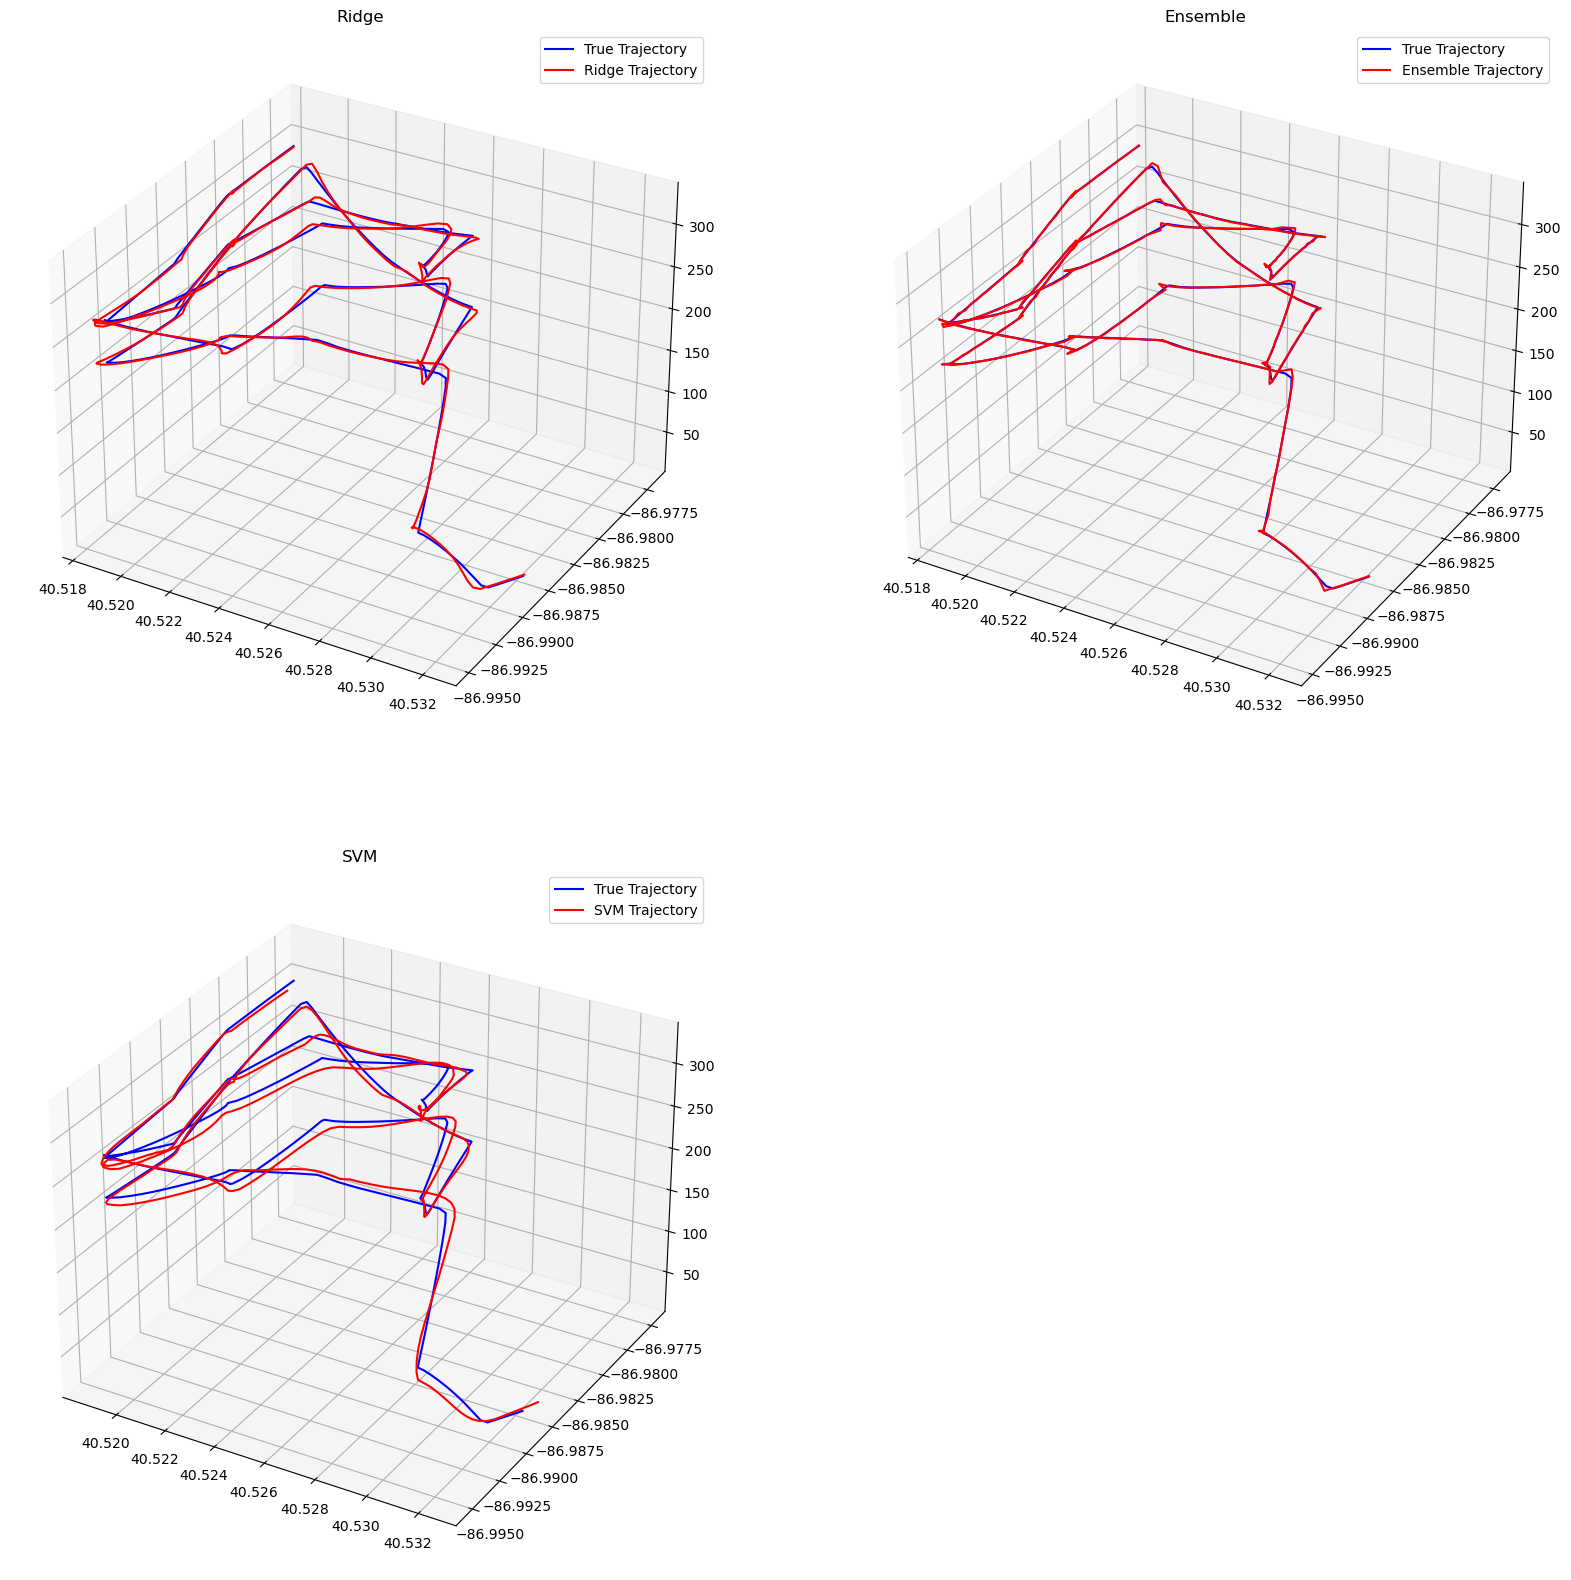

In [57]:
fig = plt.figure(figsize=(20, 20))
show_3D_trajectory(fig, 1, Ridge_predict_list, 'Ridge')
show_3D_trajectory(fig, 2, BR_best_test_predict_list, 'Ensemble')
show_3D_trajectory(fig, 3, rbf_test_predict_list, 'SVM')

{'TRidge_MAE': 0.24422725769211695,
 'TRidge_RMSE': 0.36359883970092527,
 'TRidge_MAPE': 0.2502159599687385,
 'TBR_MAE': 0.15569445020236458,
 'TBR_RMSE': 1.090408677454304,
 'TBR_MAPE': 0.12954214746738776,
 'rbf_MAE': 0.5126777576594889,
 'rbf_RMSE': 0.6505543503226148,
 'rbf_MAPE': 0.28755117741384795}

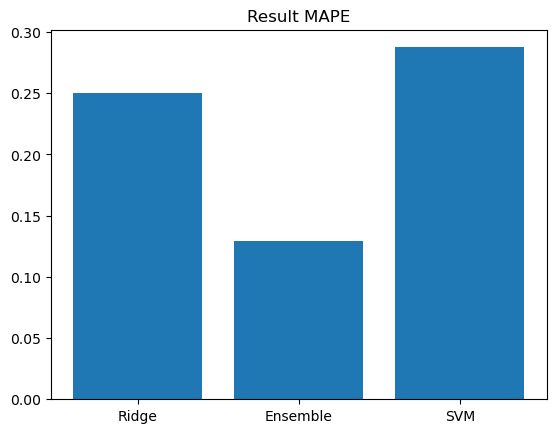

In [58]:
plt.title('Result MAPE')
models = ['Ridge', 'Ensemble', 'SVM']
ranges = np.arange(3)
values = [model_error_list['TRidge_MAPE'], model_error_list['TBR_MAPE'], model_error_list['rbf_MAPE']]
plt.bar(ranges, values)
plt.xticks(ranges, models)

model_error_list

In [59]:
Ridge_reg.best_params_["alpha"]

1

In [60]:
print('Bagging Regression')
BR_best_params

Bagging Regression


[30, 30, 30]

In [61]:
print('rbf SVM')
rbf_best_params

rbf SVM


[[0.001, 1000], [0.01, 100], [1e-05, 10000]]